In [1]:
import sys, time, os, asyncio
import scipy.stats as stats
from scipy import signal
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.time import Time
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient, clipDataToEvent, calcNextDay
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
def get_efd_data(begin, end, client):

    """Extract all the MTMount data from the EFD and add to dict.

    Args:
        begin (str): The start time of the query.
        end (str): The end time of the query.
        client (object): influx client

    Returns:
        dict: A dictionary containing the MTMount data.
    """

    query_dict = {}

    query_dict["el"] = getEfdData(
        client,
        "lsst.sal.MTMount.elevation",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=10,
        postPadding=10,
        warn=False,
    )
    query_dict["az"] = getEfdData(
        client,
        "lsst.sal.MTMount.azimuth",
        columns=["private_sndStamp", "private_efdStamp", "actualPosition", "actualVelocity", "actualTorque"],
        begin=begin,
        end=end,
        prePadding=10,
        postPadding=10,
        warn=False,
    )
    return query_dict

def get_vms_data(filename, begin, end):

    """Extract VMS data from a HDF5 file.

    Args:
        filename (str): The path to the HDF5 file.
        begin (str): The start time of the query.
        end (str): The end time of the query.

    Returns:
        pd.DataFrame: A Pandas DataFrame containing the VMS data.
    """

    f = h5py.File(filename, 'r')
    times = f['timestamp'][::1]
    mkeys = [1, 2, 3]
    dkeys = 'XYZ'
    t_begin = t_index(begin_time)
    t_end = t_index(end_time)
    sel = (times > begin_time) & (times < end_time)
    data_dict = {}
    data_dict['times'] = times[sel]  
    for i, m in enumerate(mkeys):
        for j, d in enumerate(dkeys):
            key = f'{m} {d}'
            data_dict[key_dict[key]] = f[key][::1][sel]
    data_frame = pd.DataFrame(data_dict)
    return data_frame

In [52]:
key_dict={'1 X': 'm1m3_x', 
          '1 Y': 'm1m3_y', 
          '1 Z': 'm1m3_z', 
          '2 X': 'm2_x', 
          '2 Y': 'm2_y', 
          '2 Z': 'm2_z', 
          '3 X': 'cr_x', 
          '3 Y': 'cr_y', 
          '3 Z': 'cr_z'
}
vms_filename="/scratch/b1quint/vms-data/2023/05/M1M3-2023-05-26T0000.hdf"

### setup tma events

In [3]:
dayObs=20230526
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)
slews=[e for e in events if e.type==TMAState.SLEWING]

### query data

In [162]:
event=slews[20]
print(event)
begin_time=event.begin.unix
end_time=event.end.unix
efd_dict=get_efd_data(event.begin, event.end, eventMaker.client)
vms_data=get_vms_data(vms_filename, begin_time, end_time)

dayObs: 20230526
seqNum: 20
type: SLEWING
endReason: STOPPED
duration: 43.136321783065796
begin: <Time object: scale='utc' format='unix' value=1685129328.6286771>,
end: <Time object: scale='utc' format='unix' value=1685129371.764999>


### Plots
 - First plot is just plotting the vms data (and elevation telemetry)
 - second plot is spectrograms of the vms data

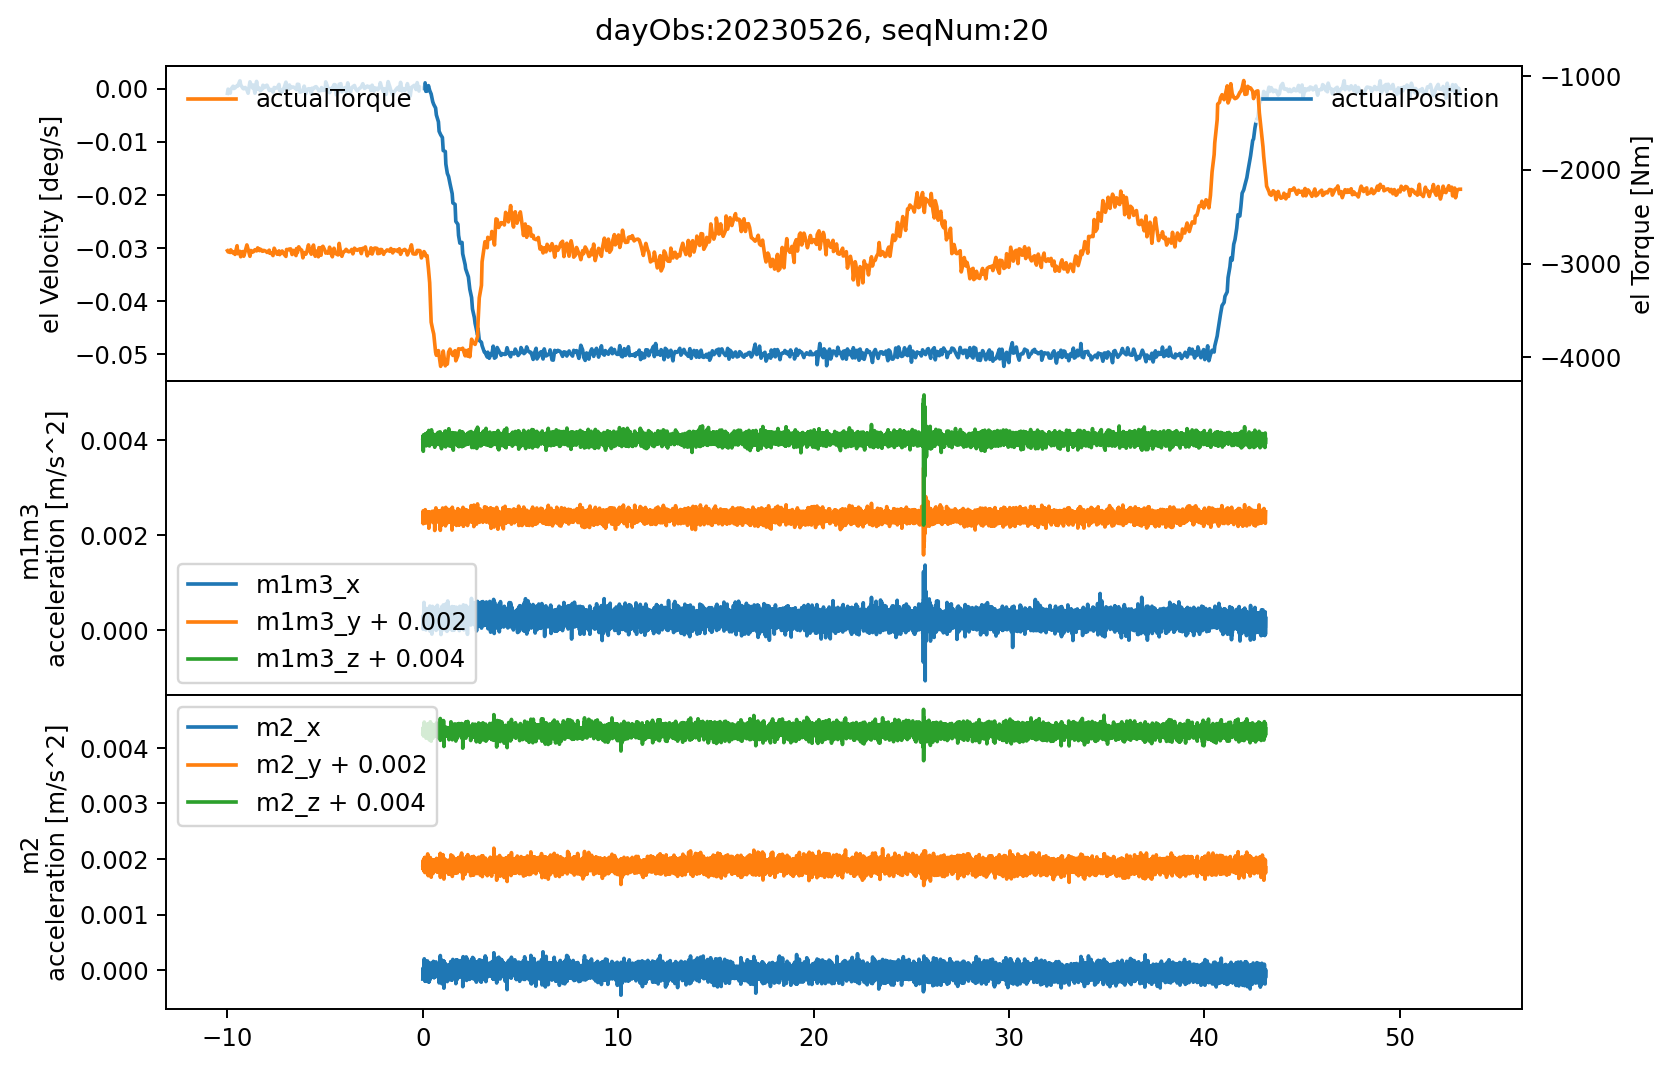

In [180]:
fig, ax=plt.subplots(3, dpi=175, sharex=True, figsize=(10,7))
plt.suptitle(f"dayObs:{event.dayObs}, seqNum:{event.seqNum}", y=0.92)
ax[0].plot((Time(efd_dict["el"]["private_sndStamp"], format="unix_tai", scale="utc")- event.begin).sec,
           efd_dict["el"]["actualVelocity"],
           color="tab:blue", label="actualPosition")
ax[0].legend(edgecolor="white", loc=1)
ax[0].set_ylabel("el Velocity [deg/s]")

ax2=ax[0].twinx()
ax2.plot((Time(efd_dict["el"]["private_sndStamp"], format="unix_tai", scale="utc")- event.begin).sec,
         efd_dict["el"]["actualTorque"],
         color="tab:orange", label="actualTorque")
ax2.legend(edgecolor="white", loc=2)
ax2.set_ylabel("el Torque [Nm]")

ax[1].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m1m3_x"],
           label="m1m3_x")
ax[1].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m1m3_y"] + 0.002,
           label="m1m3_y + 0.002")
ax[1].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m1m3_z"] + 0.004,
           label="m1m3_z + 0.004"
          
          )
ax[1].legend()
ax[1].set_ylabel("m1m3\nacceleration [m/s^2]")

ax[2].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m2_x"],
           label="m2_x")
ax[2].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m2_y"] + 0.002,
           label="m2_y + 0.002")
ax[2].plot((Time(vms_data["times"], format="unix")- event.begin).sec, 
           vms_data["m2_z"] + 0.004,
           label="m2_z + 0.004"
          
          )
ax[2].legend()
ax[2].set_ylabel("m2\nacceleration [m/s^2]")
ax[2]
plt.subplots_adjust(hspace=0)

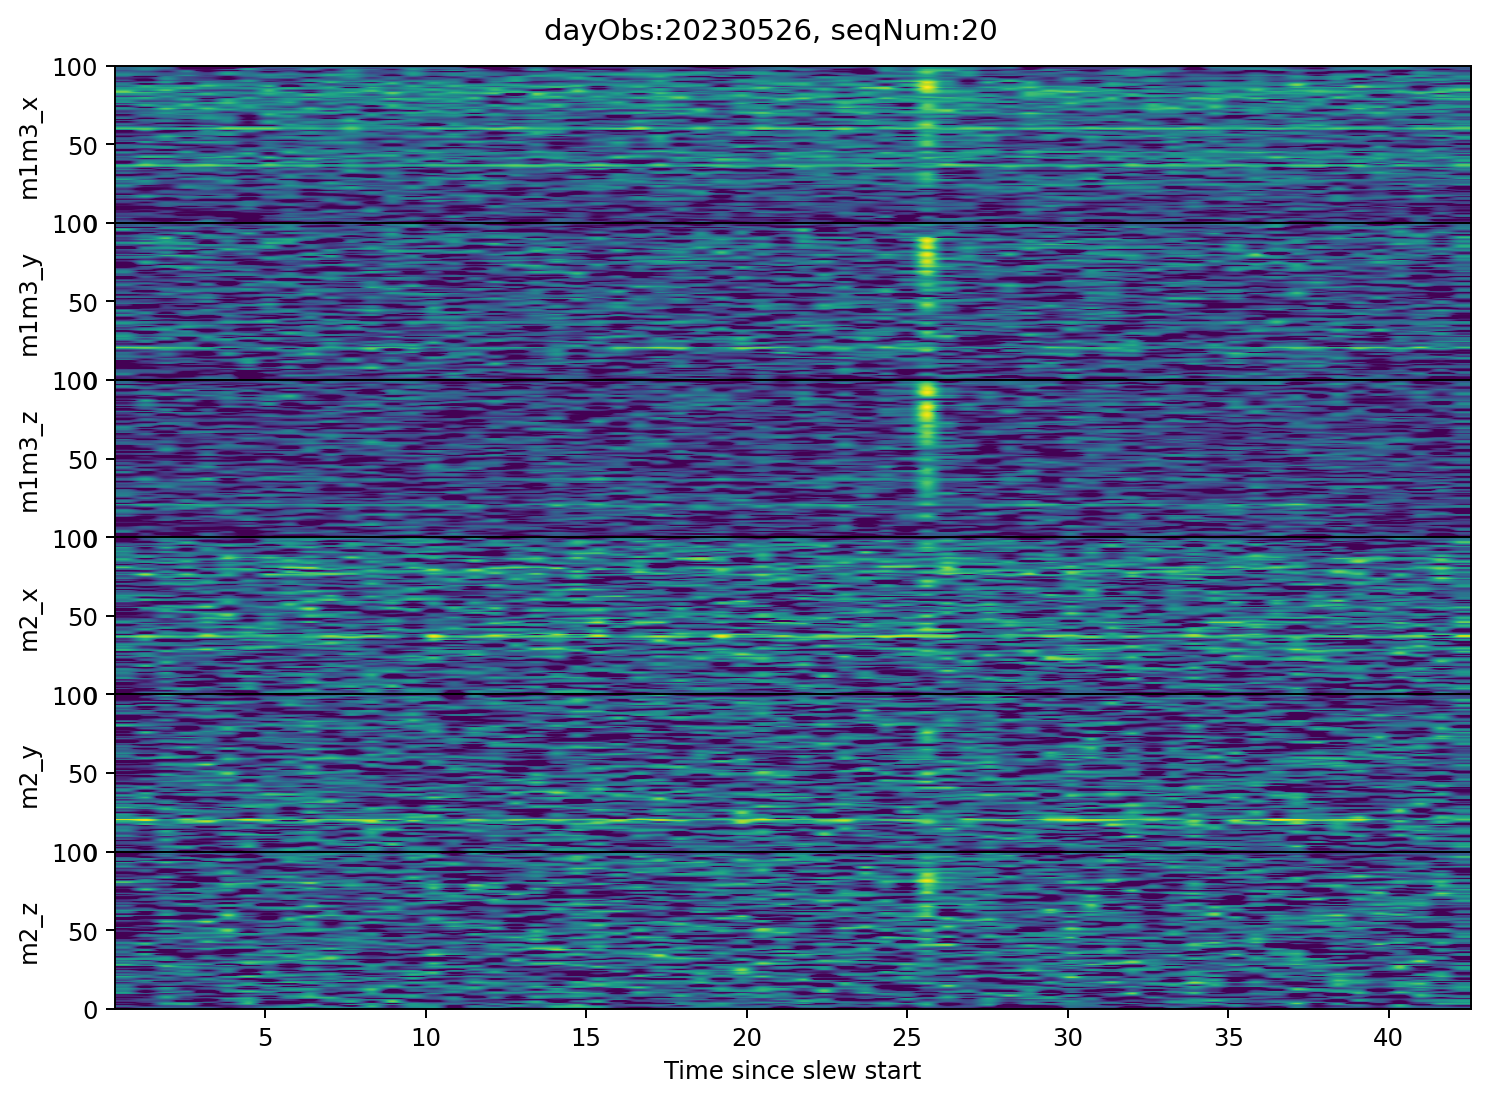

In [181]:
fig,axs=plt.subplots(6, dpi=175, figsize=(10,7), sharex=True)
plt.suptitle(f"dayObs:{event.dayObs}, seqNum:{event.seqNum}", y=0.92)
for i,key in enumerate([i for i in key_dict.values() if ("m1m3" in i) or ("m2" in i)]):
    ax=axs[i]
    ax.specgram(vms_data[key], Fs=fs, detrend="mean", vmin=-110)
    ax.set_ylabel(key)

ax.set_xlabel("Time since slew start")
plt.subplots_adjust(hspace=0)

In [122]:
fs = round(1/np.mean(np.diff(vms_data["times"])))

In [123]:
fs

200

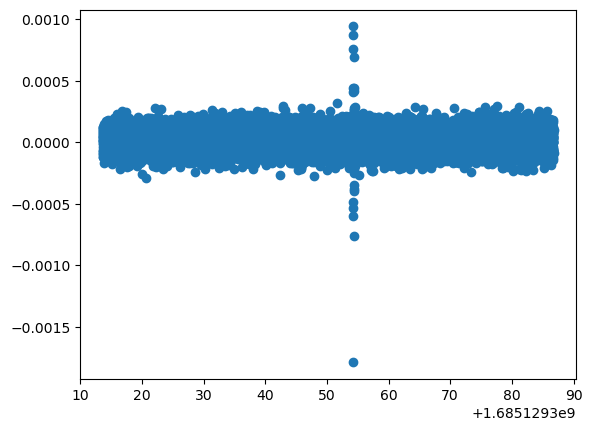

In [75]:
plt.scatter(data_frame["times"], data_frame["m1m3_z"])

In [7]:
def open_hdf(fname, begin_time, end_time):
    f = h5py.File(fname, 'r')
    times = f['timestamp'][::1]
    
        full_times = times[::1]
        t_ndx = lambda x : np.argmin(np.abs(x - full_times))   # Find the index that is closest to the given timestamp
        t_start = t_ndx(t_range[0])
        t_end = t_ndx(t_range[1])
        del full_times # Explicitly delete the data to make sure we aren't using too much memory
        print(f"Using (index, timestamp):  ({t_start}, {t_range[0]}) and ({t_end}, {t_range[1]})")
        ndx_filt = [int(t_start), int(t_end), 1]
    time_subset = times[ndx_filt[0]:ndx_filt[1]:ndx_filt[2]]
    num_times = np.sum(time_subset > 0) # String of 0s at the end of file that we don't want to read in
    treal = time_subset[:num_times] - time_subset[0]
    
    mkeys = [1,2,3]
    dkeys = 'XYZ'
    all_data = np.zeros((3,3,num_times))
    key_data = {}

    for i,m in enumerate(mkeys):
        for j,d in enumerate(dkeys):
            key = f'{m} {d}'
            dload = f[key]
            key_data[i,j] = key # Convenience object to map from [i,j] to data set
            all_data[i,j] = dload[ndx_filt[0]:ndx_filt[1]:ndx_filt[2]][:num_times]
    f.close()
    return all_data, key_data, time_subset[:num_times]

In [8]:
hdf_data, key_order, hd_time = open_hdf(filename, t_range=None)

In [19]:
key_order.values()

dict_values(['1 X', '1 Y', '1 Z', '2 X', '2 Y', '2 Z', '3 X', '3 Y', '3 Z'])

In [24]:
vmd_dict={}
vmd_dict["time"]=hd_time
for key in key_order.keys():
    vmd_dict[key_dict[key_order[key]]]=hdf_data[key]

In [27]:
pd.DataFrame(vmd_dict)

,time,m1m3_x,m1m3_y,m1m3_z,m2_x,m2_y,m2_z,cr_x,cr_y,cr_z
0,1.685107e+09,0.000257,0.000366,0.000080,-0.000044,-0.000067,0.000307,0.000286,0.000362,0.000206
1,1.685107e+09,0.000224,0.000465,0.000124,-0.000047,-0.000070,0.000331,0.000451,0.000378,0.000276
2,1.685107e+09,0.000261,0.000446,0.000042,-0.000135,-0.000137,0.000267,0.000273,0.000322,0.000147
3,1.685107e+09,0.000359,0.000362,-0.000004,-0.000038,-0.000086,0.000317,0.000343,0.000271,0.000174
4,1.685107e+09,0.000099,0.000364,-0.000006,0.000057,-0.000011,0.000420,0.000275,0.000288,0.000191
...,...,...,...,...,...,...,...,...,...,...
19995,1.685107e+09,0.000258,0.000448,0.000070,-0.000017,-0.000086,0.000288,0.000303,0.000341,0.000141
19996,1.685107e+09,0.000284,0.000362,-0.000013,0.000071,-0.000025,0.000360,0.000378,0.000277,0.000149
19997,1.685107e+09,0.000341,0.000462,0.000071,0.000084,-0.000027,0.000395,0.000324,0.000360,0.000210
19998,1.685107e+09,0.000278,0.000409,0.000046,-0.000037,-0.000141,0.000305,0.000353,0.000319,0.000175


In [ ]:
plt.figure()
plt.hist(Time(times, format="unix_tai").datetime)